In [ ]:
# Use for SageMaker
#!pip install --upgrade pip
#!pip install WordCloud

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

from wordcloud import WordCloud

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from src import utils, nlp_utils, web_app_utils

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Visualizations for Website

## Import Data

In [2]:
wallstreet = pd.read_csv('data/wallstreet_master.csv', engine='python')

In [3]:
wallstreet.head()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,contentWithHTMLTag,post_date_time,author_join_date,post_date,num_days_member_when_posted,processed_text,parts_of_speech,cleaned_post,compound_sentiment
0,6,5,Hi,Introductions,Punka421,New member,-3,1,"<div class=""entry-content"">\n<p>Just thought I...",2016-10-26 13:58:36,2016-10-26 00:00:00,2016-10-26,0.0,"['thought', 'introduce', 'new', 'community', '...","[('thought', 'VBN'), ('introduce', 'VB'), ('ne...",thought introduce new community trying learn m...,0.9287
1,7,5,Hi,Introductions,WSM,Administrator,66,2,"<div class=""entry-content"">\n<p>Hello <img alt...",2016-10-26 14:04:04,2016-10-02 00:00:00,2016-10-26,24.0,"['hello', 'nice', 'see', 'regard']","[('hello', 'JJ'), ('nice', 'JJ'), ('see', 'NN'...",hello nice see regard,0.4215
2,8,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,1,"<div class=""entry-content"">\n<p>Hello everyone...",2016-10-26 16:54:27,2016-10-02 00:00:00,2016-10-26,24.0,"['hello', 'everyone', 'like', 'tell', 'impleme...","[('hello', 'RB'), ('everyone', 'NN'), ('like',...",hello everyone like tell implemented new featu...,0.9825
3,11,5,Hi,Introductions,Estrazy,Banned,0,3,"<div class=""entry-content"">\n<p>Hello Punka! n...",2016-10-27 14:00:16,2016-10-27 00:00:00,2016-10-27,0.0,"['hello', 'punka', 'nice', 'meet', 'asked', 's...","[('hello', 'NN'), ('punka', 'NN'), ('nice', 'J...",hello punka nice meet asked stay secure tip ca...,0.9022
4,13,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,2,"<div class=""entry-content"">\n<h5>Changelog fro...",2016-11-02 15:42:27,2016-10-02 00:00:00,2016-11-02,31.0,"['changelog', 'wednesday', 'november', 'lot', ...","[('changelog', 'NN'), ('wednesday', 'JJ'), ('n...",changelog wednesday november lot small issue b...,0.8720


## Daily Forum Posts

In [ ]:
def plot_daily_post_freq(series):
    '''
    Interactive line plot showing the number of plots per day.
    '''
    daily_post_freq = pd.DataFrame(series.value_counts()).reset_index()
    daily_post_freq.columns = ['date', 'count']
    daily_post_freq.sort_values(['date'], axis=0, inplace=True)
    fig = px.line(data_frame=daily_post_freq, x='date', y='count',
                  labels={'date': 'Date', 'count': '# of Posts'})
    fig.update_layout(width=1500, height=600)
    fig.show()
    fig.write_image("img/daily_posts.jpg")

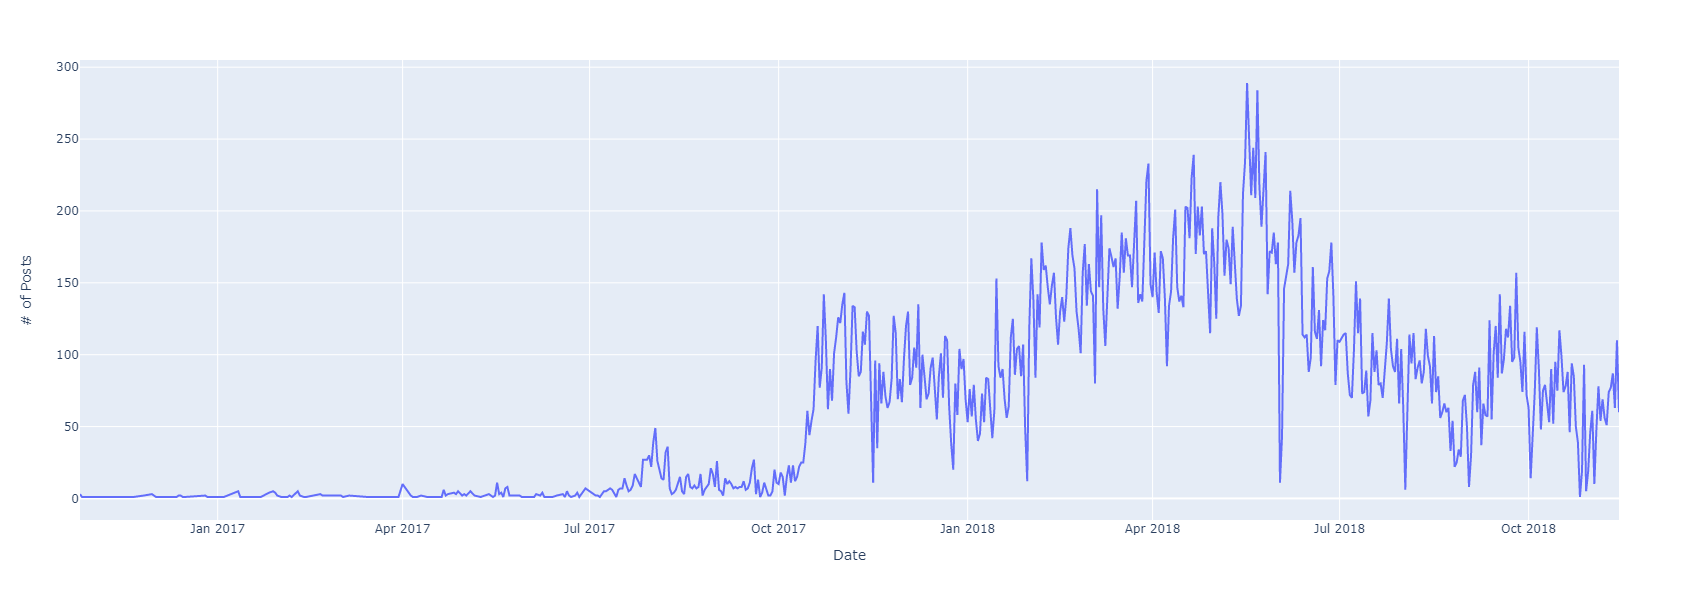

In [5]:
series = wallstreet['post_date']

html_data=web_app_utils.plot_daily_post_freq(series)


In [6]:
print(html_data)

None


## Wordcloud

In [ ]:
web_app_utils.display_wordcloud(wallstreet['cleaned_post'], 10000, True)

In [ ]:
web_app_utils.display_wordcloud(wallstreet['cleaned_post'], 10000, False)

---
# Sentiment Time-Series Analysis

In [ ]:
start_date = '2017-10-14'
sentiment_df = wallstreet[wallstreet['post_date'] > start_date].copy()

sentiment_scores = sentiment_df['compound_sentiment']
sorted_sentiment_scores = sorted(sentiment_scores)
median_idx = int(len(sentiment_scores)/2)

# Lifetime Stats
utils.stats_summary(sentiment_scores)

In [ ]:
# Lifetime Metrics
# Use median and IQR b/c distribution is not a "pure" Gaussian.
# Sentiment score distribution is a combination of a Gaussian and skewed-right distribution.
lifetime_mean = sentiment_scores.mean()
lifetime_median = sentiment_scores.median()
lifetime_q1 = np.median(sorted_sentiment_scores[:median_idx])
lifetime_q3 = np.median(sorted_sentiment_scores[median_idx:])


print('Median Check: ', sorted_sentiment_scores[median_idx] - lifetime_median)

In [ ]:
daily_sentiment = sentiment_df.groupby('post_date')['compound_sentiment'].aggregate(['min', 'max', 'mean', 'median', 'std', 'count']).reset_index()
daily_sentiment.columns = ['date', 'min', 'max', 'mean', 'median', 'std_dev', 'count']

In [ ]:
date_arr = daily_sentiment['date'].values
n_chars = len(date_arr)

# liftime metrics
lt_mean_arr = np.full(n_chars, lifetime_mean)
lt_median_arr = np.full(n_chars, lifetime_median)
lt_q1_arr = np.full(n_chars, lifetime_q1)
lt_q3_arr = np.full(n_chars, lifetime_q3)

# daily metrics
daily_mean_arr = daily_sentiment['mean'].values
daily_median_arr = daily_sentiment['median'].values
daily_max_arr = daily_sentiment['max'].values
daily_min_arr = daily_sentiment['min'].values

# Create dataframe to export data.
sentiment_plot_data = pd.DataFrame()
sentiment_plot_data['Lifetime Avg'] = lt_mean_arr
sentiment_plot_data['Lifetime Median'] = lt_median_arr
sentiment_plot_data['Lifetime IQ1'] = lt_q1_arr
sentiment_plot_data['Lifetime IQ3'] = lt_q3_arr
sentiment_plot_data['Daily Avg'] = daily_mean_arr
sentiment_plot_data['Daily Median'] = daily_median_arr
sentiment_plot_data['Daily Max'] = daily_max_arr
sentiment_plot_data['Daily Min'] = daily_min_arr

sentiment_plot_data.to_csv('data/sentiment_analysis_data.csv', index=False)

In [ ]:



# Plotly line plot
fig = go.Figure()
fig.update_layout(width=1800, height=700,yaxis=dict(range=[-1.1,1.1]))

# LIFETIME METRICS
#fig.add_trace(go.Scatter(x=date_arr, y=lt_mean_arr, name='Lifetime Avg.', line=dict(color='blueviolet', width=3)))
fig.add_trace(go.Scatter(x=date_arr, y=lt_median_arr, name='Lifetime Median', line=dict(color='orangered', width=3)))

fig.add_trace(go.Scatter(x=date_arr, y=lt_q1_arr, name='Lifetime Q1',
                         line=dict(color='springgreen', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=date_arr, y=lt_q3_arr, name='Lifetime Q3',
                         line=dict(color='springgreen', width=2, dash='dash')))



# DAILY METRICS
#fig.add_trace(go.Scatter(x=date_arr, y=daily_mean_arr, name='Daily Avg.', line=dict(color='dodgerblue', width=2)))
fig.add_trace(go.Scatter(x=date_arr, y=daily_median_arr, name='Daily Median', line=dict(color='lightcoral', width=2)))

fig.add_trace(go.Scatter(x=date_arr, y=daily_max_arr, name='Daily Max',
                         line=dict(color='orange', width=3, dash='dot')))
fig.add_trace(go.Scatter(x=date_arr, y=daily_min_arr, name='Daily Min',
                         line=dict(color='orange', width=3, dash='dot')))

fig.show();